In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import networkx as nx
import statsmodels.formula.api as smf

from statsmodels.stats import diagnostic
from scipy import stats

import json


In [206]:
filename = f"yt_metadata_filtered_trump.jsonl.gz"
df = pd.read_json(filename, lines=True, compression='gzip') # read the dataset


In [207]:
df = df[df['categories'] == 'Entertainment'] # Filter out all videos with the category "entertainment."

In [208]:
df = df.dropna(subset=['like_count', 'dislike_count', 'view_count', 'duration'])

In [209]:
df = df[df['view_count'] >= 3000] # Filter out videos with view counts greater than or equal to 3000.

In [210]:
# Filter out all channel IDs that have produced 8 or more entertainment videos related to Trump.
channel_counts = df['channel_id'].value_counts()
channel_ids = channel_counts[channel_counts >= 8]
channel_ids.describe()

count      322.000000
mean        85.437888
std        824.323458
min          8.000000
25%         11.000000
50%         18.000000
75%         38.000000
max      14764.000000
Name: count, dtype: float64

In [211]:

valid_channel_ids = channel_ids.index
df = df[df['channel_id'].isin(valid_channel_ids)]


In [212]:
df.to_csv('filtered_df_enttm.csv', index=False)

In [213]:
with open('conspiracy_words.json', 'r') as f:
    conspiracy_data = json.load(f) # Read the JSON file

conspiracy_names = [theory['name'] for theory in conspiracy_data['conspiracy_theories']] # get all the 'name's in the json file

In [214]:
# Create a boolean index to check if the title or tags contain any of the conspiracy_names.
conspiracy_check = df['title'].str.contains('|'.join(conspiracy_names), case=False, na=False) | \
                   df['tags'].str.contains('|'.join(conspiracy_names), case=False, na=False)

# Assign the boolean values directly to the 'conspiracy' column as integers (1 for True, 0 for False)
df.loc[:, 'conspiracy'] = conspiracy_check.astype(int)

In [215]:
treated = df.loc[df['conspiracy'] == 1] # Videos that contain conspiracy keywords in the title or tags.
control = df.loc[df['conspiracy'] == 0] # Videos that do not contain conspiracy keywords in the title or tags.

In [216]:
treated.like_count.describe()

count      557.000000
mean      2397.095153
std       2620.605348
min         15.000000
25%        703.000000
50%       1459.000000
75%       3640.000000
max      23551.000000
Name: like_count, dtype: float64

In [217]:
control.like_count.describe()


count    2.695400e+04
mean     3.393077e+03
std      1.354564e+04
min      0.000000e+00
25%      3.950000e+02
50%      1.031000e+03
75%      2.277000e+03
max      1.235449e+06
Name: like_count, dtype: float64

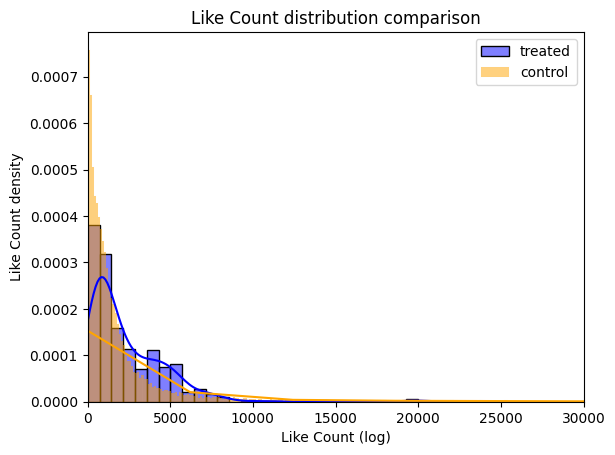

In [218]:
ax = sns.histplot(treated['like_count'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(control['like_count'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Like Count distribution comparison',xlabel='Like Count (log)', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

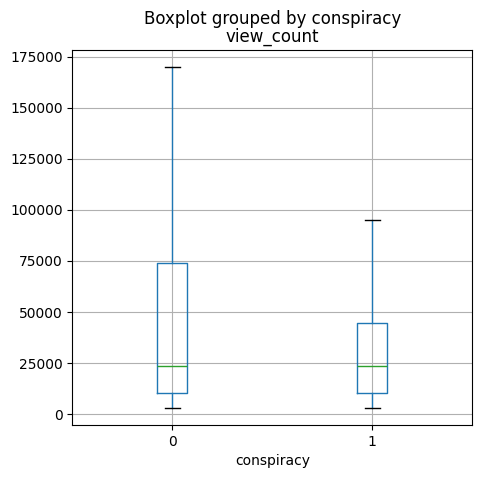

In [219]:
df.boxplot(by='conspiracy', column='view_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()
# Although the median of the control group is close to that of the treat group, 
# videos above the upper quartile in the control group can have more views.

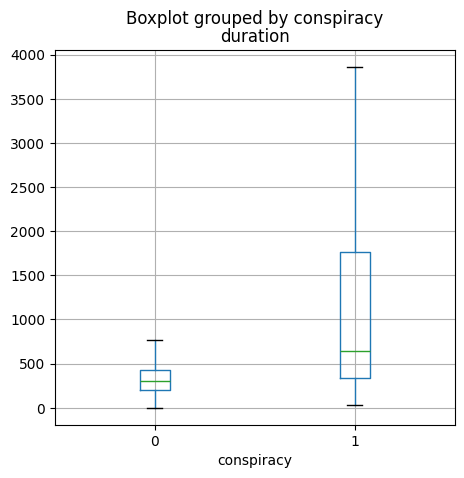

In [220]:
df.boxplot(by='conspiracy', column='duration', figsize = [5, 5], grid=True, showfliers=False)
plt.show()
# Videos in the treat group are often longer than those in the control group.

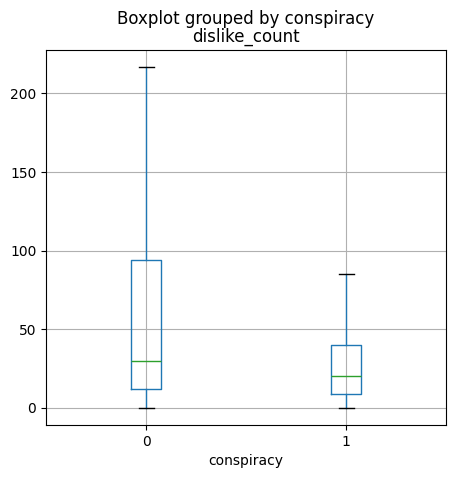

In [221]:
df.boxplot(by='conspiracy', column='dislike_count', figsize = [5, 5], grid=True, showfliers=False)
plt.show()
# Although the median of the control group is close to that of the treat group, 
# videos above the upper quartile in the control group can have more dislikes.

In [222]:
# Standardize the features
df['dislike_count'] = (df['dislike_count'] - df['dislike_count'].mean())/df['dislike_count'].std()
df['duration'] = (df['duration'] - df['duration'].mean())/df['duration'].std()
df['view_count'] = (df['view_count'] - df['view_count'].mean())/df['view_count'].std()

In [223]:
mod = smf.logit(formula='conspiracy ~ dislike_count + duration + view_count', data=df)

res = mod.fit()

# Extract the estimated propensity scores
df['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.096073
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:             conspiracy   No. Observations:                27511
Model:                          Logit   Df Residuals:                    27507
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                 0.02953
Time:                        00:28:50   Log-Likelihood:                -2643.1
converged:                       True   LL-Null:                       -2723.5
Covariance Type:            nonrobust   LLR p-value:                 1.189e-34
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.4204      0.108    -40.919      0.000      -4.632      -4.209
dislike_count    -5

c:\Users\73597\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\73597\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [224]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [225]:
treated = df.loc[df['conspiracy'] == 1] # Videos that contain conspiracy keywords in the title or tags.
control = df.loc[df['conspiracy'] == 0] # Videos that do not contain conspiracy keywords in the title or tags.
control_sample = control.sample(frac=0.021, random_state=42) # Randomly sample from the control group to reduce running time.


In [226]:
treated.like_count.describe()

count      557.000000
mean      2397.095153
std       2620.605348
min         15.000000
25%        703.000000
50%       1459.000000
75%       3640.000000
max      23551.000000
Name: like_count, dtype: float64

In [227]:
control_sample.like_count.describe()

count      566.000000
mean      2580.802120
std       5162.951799
min          6.000000
25%        441.250000
50%       1058.500000
75%       2165.000000
max      52591.000000
Name: like_count, dtype: float64

In [228]:


# Create an empty undirected graph
G = nx.Graph()
i = 0
# Loop through all the pairs of instances
for control_id, control_row in control_sample.iterrows():
    for treatment_id, treatment_row in treated.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

        

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [229]:
# Create a list of matched indices
matched = []
for pair in matching:
    matched.append(pair[0])  # Control group index
    matched.append(pair[1])  # Treatment group index

# Create balanced DataFrame using original indices
balanced_df_1 = df.loc[df.index.isin(matched)]

In [230]:
treated = balanced_df_1.loc[balanced_df_1['conspiracy'] == 1]
control = balanced_df_1.loc[balanced_df_1['conspiracy'] == 0]

In [231]:
treated.like_count.describe()

count      557.000000
mean      2397.095153
std       2620.605348
min         15.000000
25%        703.000000
50%       1459.000000
75%       3640.000000
max      23551.000000
Name: like_count, dtype: float64

In [232]:
control.like_count.describe()

count      557.000000
mean      2374.005386
std       4291.889828
min          6.000000
25%        441.000000
50%       1054.000000
75%       2155.000000
max      33012.000000
Name: like_count, dtype: float64

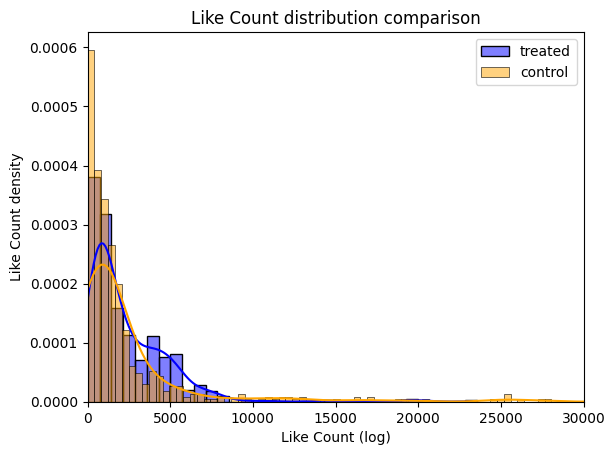

In [233]:
ax = sns.histplot(treated['like_count'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(control['like_count'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Like Count distribution comparison',xlabel='Like Count (log)', ylabel='Like Count density')
# plt.xscale('log')
plt.xlim(0,30000)
plt.legend()
plt.show()

In [234]:
stats.ttest_ind(treated['like_count'], control['like_count'], alternative='greater') # t-Test

TtestResult(statistic=0.10836544977385142, pvalue=0.45686267817793047, df=1112.0)

- p is not smaller than 0.05 -> we cannot reject the null hypothesis that the income is the same -> there is no significant difference